<a href="https://colab.research.google.com/github/Brendannigel/Introduction-to-GANs-with-Python-and-TensorFlow/blob/master/JEB1433_DCGAN_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Import the required packages and libraries

import tensorflow as tf
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import PIL

from IPython import display

In [0]:
# Load in the MNIST data set for training the generator and discriminator networks

(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

# Reshape the images for the networks

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # this is used to normalize the images to [-1, 1]

BUFFER_SIZE = 60000 
BATCH_SIZE = 256

# Batch and shuffle the data

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Define the model for the generator network
# Each new paragraph represents a new layer in the network
# In order to make DCGAN the first layer must start with a dense layer but WGAN
## in this paper starts with a cnvolutional layer

def g_net():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(256, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 256)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())


  model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (3, 3), strides=(2,2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

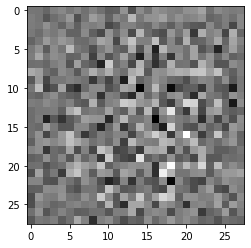

In [0]:
# Create an image using the untrained generator to test

generator = g_net()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [0]:
# Define the model for the Discriminator network
# Each new paragraph represents a new layer in the network

def d_net():
  model=tf.keras.Sequential()
  model.add(layers.Conv2D(64, (3,3), strides = (1,1), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3,3), strides = (1,1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3,3), strides = (1,1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3,3), strides = (2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024))
  model.add(layers.Dense(1))
 
  return model


In [0]:
# Untrained discriminator network to classify the generated images as either
## real or fake. Positive value = real image, negative = fake image

discriminator = d_net()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[3.2832322e-05]], shape=(1, 1), dtype=float32)


In [0]:
# Use Mean Squared Error as the function for loss in the network
### WGAN will use wassertein loss function here instead

mse = tf.keras.losses.MeanSquaredError()

In [0]:
# Define loss for the discriminator network
### WGAN would have used wasserstein loss here instead of MSE

def discriminator_loss(real_output, fake_output):
  real_loss = mse(tf.ones_like(real_output), real_output)
  fake_loss = mse(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [0]:
# Define loss for the Generator Network

def generator_loss(fake_output):
  return mse(tf.ones_like(fake_output), fake_output)

In [0]:
# Define the optimizers for the Discriminator and Generator
# Adam optimizer was used

generator_optimizer = tf.keras.optimizers.Adam(1e-5, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5, 0.5)

In [0]:
# Save checkpoints in case of task interruption

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
# Define the training loop for the networks

EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [0]:
# Here we start to define the training loop

@tf.function # Using the tf.fucntion allows the function to be compiled. Instead of using normal .compile
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as discrim_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    discrim_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = discrim_tape.gradient(discrim_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

# save the images as the code moves along and we want it to save every 15 epochs

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch +1, seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epocch {} is {} seconds'.format(epoch + 1, time.time()-start))

# Generate after the final epoch

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4, i+1)
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

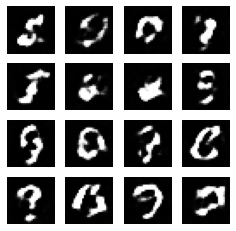

In [0]:
# Call on train() to train the network and get image outputs

train(train_dataset, EPOCHS)

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [0]:
display_image(16)